In [1]:
import torch
import torch.nn as nn
from torch_geometric.data import Batch, Data

import numpy as np
import matplotlib.pyplot as plt

from layers.ect import EctLayer
from layers.config import EctConfig

from datasets.mnist import MnistDataModule 
from datasets.config import MnistDataModuleConfig

from pytranskit.optrans.continuous.cdt import CDT
from matplotlib import animation
plt.rcParams["animation.html"] = "jshtml"


dataset = MnistDataModule(MnistDataModuleConfig())



KeyboardInterrupt: 

In [ ]:
NUM_PTS = 100
DEVICE = 'cuda:0'
NUM_THETAS = 64

V = torch.vstack(
    [
        torch.sin(torch.linspace(0, 2 * torch.pi, NUM_THETAS,device=DEVICE)),
        torch.cos(torch.linspace(0, 2 * torch.pi, NUM_THETAS,device=DEVICE)),
    ]
)


CONFIG = EctConfig(num_thetas=NUM_THETAS,bump_steps=NUM_THETAS,normalized=True,device=DEVICE)


# Interpolation

In [ ]:
def cdt_interpolation(ect_start, ect_end,steps=100):
    ect_start = ect_start.cpu().squeeze().detach().numpy()
    ect_end = ect_end.cpu().squeeze().detach().numpy()
    N=NUM_THETAS
    x0 = np.linspace(0, 1, N)
    I0= np.ones(x0.size)
    x=np.linspace(0, 2, N)
    num_thetas = NUM_THETAS
    ect = np.zeros((num_thetas,num_thetas))
    I1 = abs(ect_start) + 1e-7
    I2 = abs(ect_end) + 1e-7

    I1 = I1/I1.sum(axis=0)
    I2 = I2/I2.sum(axis=0)
    
    taus = np.linspace(0,1,steps)
    cdt1 = CDT()
    inter = []

    for tau in taus: 
        for idx in range(num_thetas):
            # Compute the forward transform
            I1_hat, _, _ = cdt1.forward(x0, I0, x, I1[:,idx], rm_edge=False)
            I2_hat, _, _ = cdt1.forward(x0, I0, x, I2[:,idx], rm_edge=False)


            I_hat = ( tau ) * I1_hat + ( 1 - tau ) * I2_hat  
            I_recon = cdt1.inverse(I_hat, I0, x)

            ect[:,idx] = I_recon
            
        inter.append(ect)
        ect = np.zeros((num_thetas,num_thetas))
    return torch.tensor(np.stack(inter),dtype=torch.float,device=DEVICE)


def linear_interpolation(ect_start, ect_end,steps=100):
    taus = torch.linspace(0,1,steps=100,device=DEVICE).unsqueeze(1).unsqueeze(1)
    return taus * ect_start.unsqueeze(0).repeat(100,1,1) + (1-taus) *  ect_end.unsqueeze(0).repeat(100,1,1)
    




In [ ]:
derlayer = EctLayer(config = EctConfig(num_thetas=NUM_THETAS,bump_steps=NUM_THETAS,device=DEVICE,ect_type="points_derivative",normalized=True),v=V)
ectlayer = EctLayer(config = EctConfig(num_thetas=NUM_THETAS,bump_steps=NUM_THETAS,device=DEVICE,ect_type="points",normalized=True),v=V)



### Sample points from noisy circle

In [ ]:
test_batch = Batch.from_data_list(
    [
        Data(x=torch.tensor([[0.4,0.7],[-0.4,0.7]])),
        Data(x=torch.tensor([[0,-0.7]]))
    ]
).to(DEVICE)

res = ectlayer(test_batch)
res_cdt = derlayer(test_batch)

interp_linear = linear_interpolation(res[0],res[1].squeeze()).cpu()
interp_cdt = cdt_interpolation(res_cdt[0],res_cdt[1].squeeze()).cumsum(axis=1).cpu()


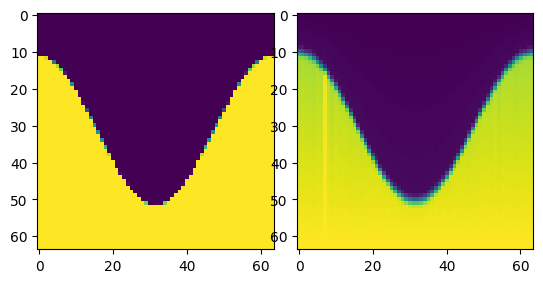

In [ ]:
# First set up the figure, the axis, and the plot element we want to animate

fig, axes = plt.subplots(nrows=1, ncols=2)
plt.subplots_adjust(wspace=.1,hspace=.1)
# axes.set_aspect(1)

# initialization function: plot the background of each frame
def init():
    axes[0].imshow(interp_linear[0])
    axes[1].imshow(interp_cdt[0])
    return None,


# animation function.  This is called sequentially
def animate(i):
    axes[0].imshow(interp_linear[i])
    axes[1].imshow(interp_cdt[i])
    

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, 
                               animate, 
                               init_func=init,
                               frames=100, 
                               interval=80
                               )

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
# anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])


anim.save('animations/ect_interp.gif', fps=30)

anim




# Reconstruction with the iRadon transform

## Remarks 

This reconstruction uses the vanilla filtered backprojection commonly used for 
inverting the radon transform. 
By taking the derivative of the ect we apply this method to obtain and 
inverse estimate of the point.
Note that the inversion yields a _propability density function_ instead of a 
point. For non-machine learning methods, one can then use a blob detector or 
local peak estimation to get an approximate for the location of the point. 

The beauty of the CDT in this case is that linear interpolation in the CDT domain
yields _linear interpolaiton in the spatial domain_, without knowing where points 
are or how many.

Another approach we outline is applying a neural network directly to the ECT or 
the interpolate and _learn_ an approximate function. 
As loss function we use the MSE loss between the ECT and the ECT of the reconstruction, 
hence using a purely topological loss. 
This works wonders, and one can approximate pointclouds with smaller pointclouds. 

BIG QUESTION: Is there a reconstruction algorithm / ml that can estimate the 
spatial location of blobs?



In [ ]:
from skimage.transform import iradon

sinograms = cdt_interpolation(res_cdt[0],res_cdt[1].squeeze()).cpu().numpy()
theta = torch.linspace(0, 360, NUM_THETAS).numpy()
recons = []
for sinogram in sinograms:
    reconstruction_fbp = iradon(sinogram.squeeze(), theta=theta, filter_name='ramp')
    recons.append(reconstruction_fbp)
reconstruction = np.stack(recons)


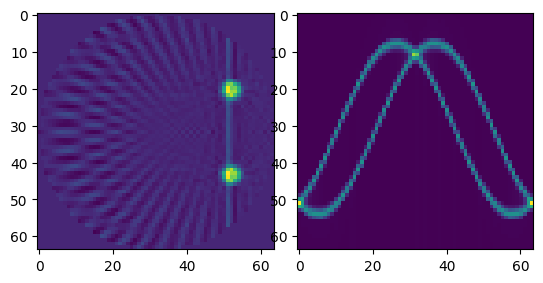

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.subplots_adjust(wspace=.1,hspace=.1)
# axes.set_aspect(1)

# initialization function: plot the background of each frame
def init():
    pass

# animation function.  This is called sequentially
def animate(i):
    axes[0].imshow(reconstruction[i])
    axes[1].imshow(sinograms[i])
    

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, 
                               animate, 
                               init_func=init,
                               frames=100, 
                               interval=80
                               )

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
# anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])


anim.save('animations/ect_reconstruction_interpolation.gif', fps=30)

anim

